In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import stats
import lightgbm as lgb

import optuna
from optuna.visualization import (
    plot_contour
    , plot_edf
    , plot_intermediate_values
    , plot_optimization_history
    , plot_parallel_coordinate
    , plot_param_importances
    , plot_slice
)

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio

pio.renderers.default = "jupyterlab"

***
## loading data

In [2]:
features = [f"f_{i}" for i in range(300)]

features = pd.read_parquet("../ump-dataset/train.parquet", columns=features)
display(features)

target = pd.read_parquet("../ump-dataset/train.parquet", columns=["target",])
display(target)

time = pd.read_parquet("../ump-dataset/train.parquet", columns=["time_id",])
display(time)

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
0,0.932573,0.113691,-0.402206,0.378386,-0.203938,-0.413469,0.965623,1.230508,0.114809,-2.012777,...,0.366028,-1.095620,0.200075,0.819155,0.941183,-0.086764,-1.087009,-1.044826,-0.287605,0.321566
1,0.810802,-0.514115,0.742368,-0.616673,-0.194255,1.771210,1.428127,1.134144,0.114809,-0.219201,...,-0.154193,0.912726,-0.734579,0.819155,0.941183,-0.387617,-1.087009,-0.929529,-0.974060,-0.343624
2,0.393974,0.615937,0.567806,-0.607963,0.068883,-1.083155,0.979656,-1.125681,0.114809,-1.035376,...,-0.138020,0.912726,-0.551904,-1.220772,-1.060166,-0.219097,-1.087009,-0.612428,-0.113944,0.243608
3,-2.343535,-0.011870,1.874606,-0.606346,-0.586827,-0.815737,0.778096,0.298990,0.114809,-1.176410,...,0.382201,0.912726,-0.266359,-1.220772,0.941183,-0.609113,0.104928,-0.783423,1.151730,-0.773309
4,0.842057,-0.262993,2.330030,-0.583422,-0.618392,-0.742814,-0.946789,1.230508,0.114809,-0.005858,...,-0.170365,0.912726,-0.741355,-1.220772,0.941183,-0.588445,0.104928,0.753279,1.345611,-0.737624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3141405,0.093530,-0.720275,-0.345497,-0.438781,-0.166972,-0.437182,1.475746,1.284423,0.056425,-1.433681,...,-0.285908,-1.232434,-0.660579,0.875537,0.421628,-0.428097,-0.075548,-0.533092,-0.193732,-0.581394
3141406,-1.344935,-0.199987,-0.107702,-0.454677,-0.221914,-0.141174,-1.498235,1.373834,0.056425,-1.211572,...,0.184517,-1.232434,-0.670493,0.875537,0.421628,-0.729949,-1.514277,0.013145,-0.890270,-0.589705
3141407,0.979489,-1.110491,1.006980,-0.467307,-0.159549,1.355671,0.150812,-0.088923,0.056425,0.996380,...,-0.756332,-1.232434,0.820784,-1.142157,0.421628,-0.363329,1.363181,-0.079106,-1.580124,-0.297625
3141408,-2.565332,0.320301,0.076600,1.380182,-0.155366,-0.689000,0.381069,-1.324759,0.056425,-1.111730,...,-0.756332,-1.232434,0.133074,-1.142157,0.421628,-0.375288,-1.514277,-0.973762,0.608647,-0.372040


,target
0,-0.300875
1,-0.231040
2,0.568807
3,-1.064780
4,-0.531940
...,...
3141405,0.033600
3141406,-0.223264
3141407,-0.559415
3141408,0.009599


,time_id
0,0
1,0
2,0
3,0
4,0
...,...
3141405,1219
3141406,1219
3141407,1219
3141408,1219


In [3]:
time_ids = np.sort(time.time_id.unique())
len(time_ids)

1211

In [4]:
n_time_steps = len(time_ids)
print("time steps:", n_time_steps)

valid_prop = 0.3
valid_size = int(valid_prop * n_time_steps)
print("valid size:", valid_size)

time steps: 1211
valid size: 363


In [5]:
valid_time_ids = time_ids[-valid_size:]

In [6]:
train_idx = time.query("time_id not in @valid_time_ids").index
valid_idx = time.query("time_id in @valid_time_ids").index

# dataframes for metric calculation
oof = target.loc[valid_idx,:].copy()
oof["time_id"] = time.loc[valid_idx,"time_id"]
features_valid = features.loc[valid_idx,:]

# input dataset for lgbm
train_dset = lgb.Dataset(
    data=features.loc[train_idx,:],
    label=target.loc[train_idx,"target"].values,
    free_raw_data=True
)
valid_dset = lgb.Dataset(
    data=features.loc[valid_idx,:],
    label=target.loc[valid_idx,"target"].values,
    free_raw_data=True
)

In [7]:
import gc
gc.collect()

35

***
## Bayesian Optimization

In [8]:
default_params = {
    'boosting': 'dart',
    'objective': 'mse',
    'metric': 'rmse',
    'learning_rate': 0.05,
    'force_col_wise': True,
    'bagging_freq': 1,
    'seed': 19,
    'verbosity': -1,
    'first_metric_only': False,
    'bin_construct_sample_cnt': int(1e8),
    'feature_pre_filter' : False,
}

In [9]:
def pearsonr(preds: np.array, dset: lgb.Dataset):
    """
    Helper function to compute Pearson correlation 
    on validation dataset for LightGBM as tracking metric.
    Args:
        preds: 1d-array with the model predictions
        dset: LightGBM dataset with the labels
    Returs:
        Tuple with the corresponding output
    """
    labels = dset.get_label()
    return 'pearsonr', stats.pearsonr(preds, labels)[0], True

In [10]:
def objective(trial):    
    sampled_params = dict(
        num_leaves = 2 ** trial.suggest_int("num_leaves_exp", 7, 7),
        feature_fraction = trial.suggest_discrete_uniform("feature_fraction", 0.1, 0.5, 0.05),
        bagging_fraction = trial.suggest_discrete_uniform("bagging_fraction", 0.7, 1.0, 0.05),
        lambda_l1 = trial.suggest_loguniform("lambda_l1", 1e-3, 1e1),
        lambda_l2 = trial.suggest_loguniform("lambda_l2", 1e-3, 1e1),
        min_data_in_leaf = trial.suggest_int("min_data_in_leaf", 500, 1000, 100),
        path_smooth = trial.suggest_float("path_smooth", 0., 20.),
        drop_rate = trial.suggest_discrete_uniform("drop_rate", 0.01, 0.2, 0.01),
        max_drop = trial.suggest_int("max_drop", 10, 50, 10),
        skip_drop = trial.suggest_discrete_uniform("skip_drop", 0.25, 0.75, 0.05),
    )
    model_params = {**default_params, **sampled_params}
    
    model = lgb.train(
        params=model_params,
        train_set=train_dset,
        num_boost_round=trial.suggest_int("num_iterations", 1000, 2000, 100),
    )
    
    # metric calculation
    _oof = oof.copy()
    _oof["pred"] = model.predict(features_valid)
    corrs = _oof.groupby("time_id").apply(lambda x: stats.pearsonr(x.target, x.pred)[0])
    corr_mean = corrs.mean()
    corr_std = corrs.std()
    
    return corr_mean            

In [11]:
do_optimize = False

study = optuna.create_study(
    study_name="lgbm-dart",
    direction='maximize',
    storage='sqlite:///lgbm-dart.db',
    load_if_exists=True,
)

if do_optimize:
    study.optimize(
        objective, 
        n_trials=1000, 
        timeout=43200, # 12-hrs
        n_jobs=1, 
        gc_after_trial=True,
    ) 

[I 2022-02-18 03:14:49,942] Using an existing study with name 'lgbm-dart' instead of creating a new one.


In [12]:
study.trials_dataframe().sort_values("value", ascending=False).head(20)

,number,value,datetime_start,datetime_complete,duration,params_bagging_fraction,params_drop_rate,params_feature_fraction,params_lambda_l1,params_lambda_l2,params_max_drop,params_min_data_in_leaf,params_num_iterations,params_num_leaves_exp,params_path_smooth,params_skip_drop,state
189,189,0.135298,2022-02-17 16:32:07.595727,2022-02-17 16:53:30.422271,0 days 00:21:22.826544,0.80,0.01,0.3,0.003096,3.715581,50,1000,1800.0,7,9.114174,0.40,COMPLETE
183,183,0.135031,2022-02-17 14:14:18.325602,2022-02-17 14:34:30.494523,0 days 00:20:12.168921,0.80,0.01,0.3,0.003357,4.418643,50,1000,1800.0,7,9.147085,0.45,COMPLETE
194,194,0.134875,2022-02-17 18:19:31.119595,2022-02-17 18:40:56.599875,0 days 00:21:25.480280,0.80,0.01,0.3,0.003740,3.650332,50,1000,1800.0,7,9.271381,0.40,COMPLETE
207,207,0.134742,2022-02-17 23:13:03.620926,2022-02-17 23:34:30.043737,0 days 00:21:26.422811,0.80,0.01,0.3,0.003165,3.209672,50,1000,1800.0,7,9.776602,0.40,COMPLETE
211,211,0.134685,2022-02-18 00:50:39.262135,2022-02-18 01:12:04.901052,0 days 00:21:25.638917,0.80,0.01,0.3,0.006089,3.105770,50,1000,1800.0,7,10.186573,0.40,COMPLETE
192,192,0.134629,2022-02-17 17:36:33.347138,2022-02-17 17:58:03.867565,0 days 00:21:30.520427,0.80,0.01,0.3,0.003959,3.700127,50,1000,1800.0,7,9.261442,0.40,COMPLETE
184,184,0.134603,2022-02-17 14:34:30.612027,2022-02-17 14:55:52.920124,0 days 00:21:22.308097,0.80,0.01,0.3,0.005328,4.254984,50,1000,1800.0,7,9.048365,0.40,COMPLETE
199,199,0.134571,2022-02-17 20:06:38.516299,2022-02-17 20:28:11.440256,0 days 00:21:32.923957,0.80,0.01,0.3,0.003174,3.553098,50,1000,1800.0,7,9.592879,0.40,COMPLETE
209,209,0.134535,2022-02-17 23:55:52.800255,2022-02-18 00:17:07.883721,0 days 00:21:15.083466,0.80,0.01,0.3,0.004146,3.169968,50,1000,1800.0,7,9.647412,0.40,COMPLETE
204,204,0.134535,2022-02-17 21:55:23.400073,2022-02-17 22:16:43.942728,0 days 00:21:20.542655,0.80,0.01,0.3,0.003179,2.328119,50,1000,1800.0,7,9.582592,0.40,COMPLETE


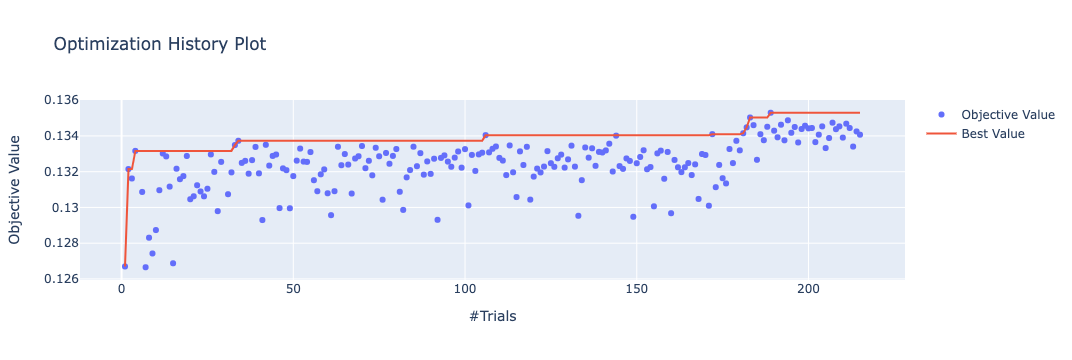

In [13]:
plot_optimization_history(study)

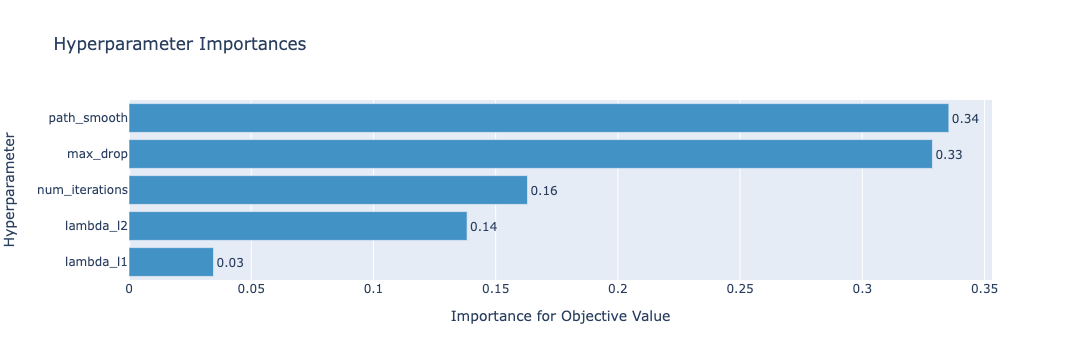

In [14]:
plot_param_importances(study)

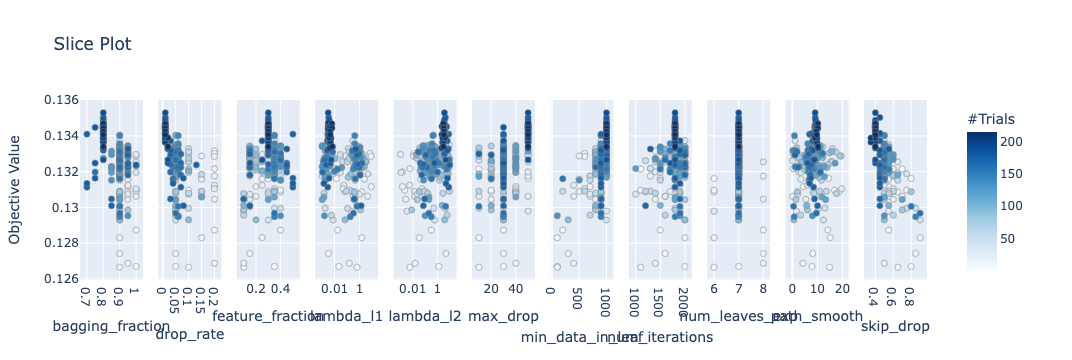

In [15]:
plot_slice(study)

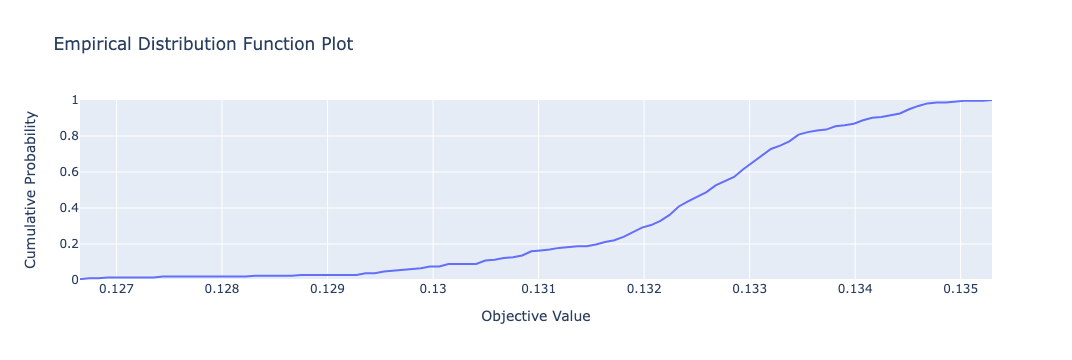

In [16]:
plot_edf(study)

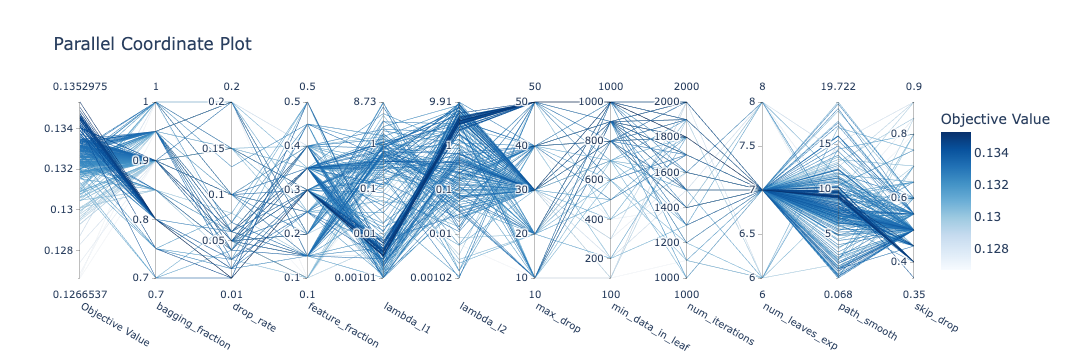

In [17]:
plot_parallel_coordinate(study)

In [18]:
best_params = dict(study.best_params)
best_params["num_leaves"] = 2**best_params.pop("num_leaves_exp")
best_params = {**default_params, **best_params}
best_params

{'boosting': 'dart',
 'objective': 'mse',
 'metric': 'rmse',
 'learning_rate': 0.05,
 'force_col_wise': True,
 'bagging_freq': 1,
 'seed': 19,
 'verbosity': -1,
 'first_metric_only': False,
 'bin_construct_sample_cnt': 100000000,
 'feature_pre_filter': False,
 'bagging_fraction': 0.7999999999999999,
 'drop_rate': 0.01,
 'feature_fraction': 0.30000000000000004,
 'lambda_l1': 0.0030962221232624376,
 'lambda_l2': 3.715581074744768,
 'max_drop': 50,
 'min_data_in_leaf': 1000,
 'num_iterations': 1800,
 'path_smooth': 9.114173802307661,
 'skip_drop': 0.4,
 'num_leaves': 128}

***